based on this notebook: https://www.kaggle.com/code/jordandelbar/credit-card-fraud-with-pytorch-autoencoder/notebook

In [101]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.preprocessing import MinMaxScaler
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report, f1_score, recall_score, precision_score

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset

In [102]:
df = pd.read_csv('./data/creditcard.csv')

In [103]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 284807 entries, 0 to 284806
Data columns (total 31 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   Time    284807 non-null  float64
 1   V1      284807 non-null  float64
 2   V2      284807 non-null  float64
 3   V3      284807 non-null  float64
 4   V4      284807 non-null  float64
 5   V5      284807 non-null  float64
 6   V6      284807 non-null  float64
 7   V7      284807 non-null  float64
 8   V8      284807 non-null  float64
 9   V9      284807 non-null  float64
 10  V10     284807 non-null  float64
 11  V11     284807 non-null  float64
 12  V12     284807 non-null  float64
 13  V13     284807 non-null  float64
 14  V14     284807 non-null  float64
 15  V15     284807 non-null  float64
 16  V16     284807 non-null  float64
 17  V17     284807 non-null  float64
 18  V18     284807 non-null  float64
 19  V19     284807 non-null  float64
 20  V20     284807 non-null  float64
 21  V21     28

In [104]:
# Since anomalies are rare events, the data is highly imbalanced
print(f"Shape of anomaly dataset:", df[df.Class == 1].shape[0])
print(f"Shape of without anomaly dataset:", df[df.Class == 0].shape[0])

Shape of anomaly dataset: 492
Shape of without anomaly dataset: 284315


In [105]:
# Split the data between features and target
x = df.drop(["Time", "Class"], axis=1).to_numpy()
y = df["Class"].to_numpy()   

# 80% of dataset is designated for training
x_train, x_test, y_train, y_test = train_test_split(
    x,
    y,
    test_size=0.2,
    stratify=y,
    random_state=random_state
)

Our autoencoder we want it to be trained only on normal (i.e., non-anomalous) events. The autoencoder attempts to recreate the data we are providing to it. Events that a trained auto-encoder cannot recreate are considered anomalous.

In [106]:
def return_normal_events_sets(x_train: np.ndarray, y_train: np.ndarray) -> tuple[np.ndarray, np.ndarray]:
    """
    Return a dataframe of the normal events
    
    Args:
        x_train: Feature dataset
        y_train: Target dataset
    """
    temp_df = pd.DataFrame(x_train)
    temp_df['label'] = y_train
    temp_array = temp_df[temp_df.label == 0].to_numpy()

    return temp_array[:, :-1], temp_array[:, -1]

In [107]:
x_normal_events, y_normal_events = return_normal_events_sets(x_train, y_train)

In [108]:
# scaling
scaler = MinMaxScaler(feature_range=(0, 1))
scaler.fit(x_train)
scaled_train_data = scaler.transform(x_normal_events)
scaled_test_data = scaler.transform(x_test)

n_features = x.shape[1]

In [109]:
random_state = 73
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [110]:
torch.manual_seed(random_state)

In [111]:
class AutoEncoder(nn.Module):
    def __init__(self, input_dim, hidden_dim):
        super(AutoEncoder, self).__init__()
        self.encoder = nn.Sequential(
            nn.Linear(input_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, hidden_dim // 2),
            nn.ReLU())
        self.decoder = nn.Sequential(
            nn.Linear(hidden_dim // 2, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, input_dim))
        
    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x

In [112]:
train = torch.tensor(scaled_train_data, dtype=torch.float32)
test = torch.tensor(scaled_test_data, dtype=torch.float32)

In [113]:
input_dim = n_features
hidden_dim = 16
autoencoder = AutoEncoder(input_dim, hidden_dim).to(device)
criterion = nn.MSELoss()
optimizer = optim.Adam(autoencoder.parameters(), lr=0.001)

In [114]:
train_loader = DataLoader(train, batch_size=50, shuffle=True, pin_memory=True)
test_loader = DataLoader(test, batch_size=50, shuffle=False, pin_memory=True)

In [115]:
epochs = 50
training_loss_list = []

for epoch in range(epochs):
    training_loss = 0.0
    for data in train_loader:
        # Move data to device
        input = data.to(device)

        # Zero the parameter gradients
        optimizer.zero_grad()

        # Forward pass
        outputs = autoencoder(input)

        # Loss
        loss = criterion(outputs, input)

        # Backward pass and optimize
        loss.backward()
        optimizer.step()
        training_loss += loss.item()

    # Compute average loss for the epoch
    average_training_loss = training_loss / len(train_loader)
    training_loss_list.append(average_training_loss)

    # Print progress
    if (epoch + 1) % 10 == 0:
        print(f"Epoch: {epoch + 1}, train loss: {average_training_loss:.4f}")

Epoch: 10, train loss: 0.0007
Epoch: 20, train loss: 0.0007
Epoch: 30, train loss: 0.0007
Epoch: 40, train loss: 0.0007
Epoch: 50, train loss: 0.0007


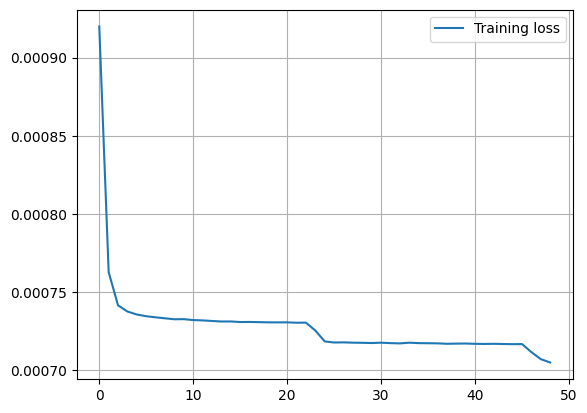

In [116]:
plt.plot(training_loss_list[1:], label="Training loss")
plt.legend()
plt.grid(True)
plt.show()

In [117]:
# Example of using the trained autoencoder for reconstruction
with torch.no_grad():
    test_input = test.to(device)
    reconstructed_output = autoencoder(test_input)

In [118]:
reconstruction_errors = []
with torch.no_grad():
    for data in test_loader:
        inputs = data.to(device)
        outputs = autoencoder(inputs)
        error = torch.mean(torch.square(outputs - inputs), dim=1)
        reconstruction_errors.extend(error.cpu().numpy())

# Set a threshold for anomaly detection
threshold = 0.003

# Detect anomalies based on the threshold
anomalies = [idx for idx, error in enumerate(reconstruction_errors) if error > threshold]

print(f"Detected {len(anomalies)} anomalies.")

Detected 735 anomalies.


In [119]:
evaluation_df = pd.DataFrame({"reconstruction_errors": reconstruction_errors, "anomaly": y_test})

Check for a range of threshold to find which one is giving be the best threshold

In [120]:
threshold_list = []
f1_scores_list = []
recall_score_list = []
precision_score_list = []

for i in np.linspace(0.001, 0.02, num=100, endpoint=True):
    evaluation_df["test"] = np.where(evaluation_df.reconstruction_errors >= i, 1, 0)
    threshold_list.append(i)
    f1_scores_list.append((i, f1_score(evaluation_df.anomaly, evaluation_df.test)))
    recall_score_list.append((i, recall_score(evaluation_df.anomaly, evaluation_df.test)))
    precision_score_list.append((i, precision_score(evaluation_df.anomaly, evaluation_df.test)))

In [121]:
f1_score_values = [i[1] for i in f1_scores_list]
recall_score_values = [i[1] for i in recall_score_list]
precision_score_values = [i[1] for i in precision_score_list]

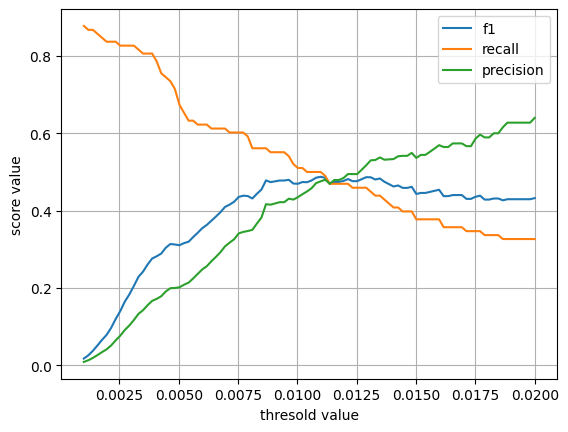

In [122]:
plt.plot(threshold_list, f1_score_values, label="f1")
plt.plot(threshold_list, recall_score_values, label="recall")
plt.plot(threshold_list, precision_score_values, label="precision")
plt.xlabel("thresold value")
plt.ylabel("score value")
plt.legend()
plt.grid(True)
plt.show()

As expected, the lower you set your threshold the higher the recall is, since you classify any data point as an anomaly! The opposite is also true, the higher you set you threshold less and less transactions are going to be considered as anomalies.

The goal now is to find a proper compromise between recall and precision but it is entirely dependent on what you want as a business outcome:

* you can aim for a high recall but it means that many normal transactions are going to be considered fraudulent, which can be non-ideal if the business strategy is to block the card in that case
* you can aim for a high precision but it means a lot of fraudulent transactions are going to possibly impact your customers

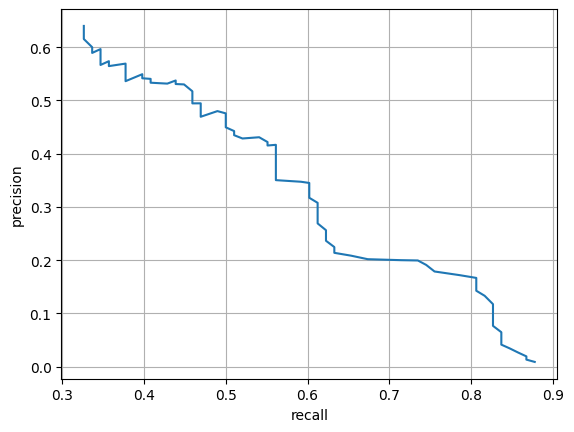

In [123]:
plt.plot(recall_score_values, precision_score_values)
plt.xlabel("recall")
plt.ylabel("precision")
plt.grid(True)
plt.show()

In [124]:
max_value = max([i[1] for i in recall_score_list])
max_index = [i[1] for i in recall_score_list].index(max_value)
print(max_value)
print(recall_score_list[max_index][0])

0.8775510204081632
0.001


In [125]:
evaluation_df["test"] = np.where(evaluation_df.reconstruction_errors >= recall_score_list[max_index][0], 1, 0)

In [126]:
confusion_matrix(evaluation_df.anomaly, evaluation_df.test)

array([[47260,  9604],
       [   12,    86]])

In [127]:
print(f1_score(evaluation_df.anomaly, evaluation_df.test))
print(recall_score(evaluation_df.anomaly, evaluation_df.test))
print(precision_score(evaluation_df.anomaly, evaluation_df.test))

0.017572537801389457
0.8775510204081632
0.008875128998968008


### Test with some fake data ...

In [134]:
print(test[0,:])
#test[0,0] = 9.9011e-01
test[0,0] = 3.9011e-01

test_loader = DataLoader(test, batch_size=1, shuffle=False, pin_memory=True)

reconstruction_errors = []
with torch.no_grad():
    for data in test_loader:
        print(data.shape) # torch.Size([1, 29])
        inputs = data.to(device)
        outputs = autoencoder(inputs)
        error = torch.mean(torch.square(outputs - inputs), dim=1)
        reconstruction_errors.extend(error.cpu().numpy())
        break
        
# Set a threshold for anomaly detection
threshold = 0.0038

# Detect anomalies based on the threshold
anomalies = [idx for idx, error in enumerate(reconstruction_errors) if error > threshold]

print(f"Detected {len(anomalies)} anomalies.")

tensor([6.9011e-01, 7.6193e-01, 8.5128e-01, 3.2273e-01, 7.5729e-01, 2.6633e-01,
        2.5791e-01, 7.8787e-01, 5.2714e-01, 5.0732e-01, 2.0711e-01, 7.4230e-01,
        5.1399e-01, 6.0534e-01, 2.8690e-01, 4.5394e-01, 7.1844e-01, 6.7132e-01,
        5.2732e-01, 5.7796e-01, 5.6444e-01, 5.5689e-01, 6.6762e-01, 3.9246e-01,
        5.6793e-01, 3.3933e-01, 4.1881e-01, 3.1281e-01, 1.9306e-04])
torch.Size([1, 29])
Detected 1 anomalies.
